In [264]:
import sys  
sys.path.insert(0, './machine_learning_models')

from logistic_regression import logistic_regression
from stochastic_gradient_descent import stochastic_gradient_descent
from knn import knn
from kernel_svm import kernel_svm
from naive_bayes import naive_bayes
from random_forest import random_forest
from voting_classifier import voting_classifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

In [265]:
league_id = 39 # Choose the league id
min_threshold = 1.75
max_threshold = 10

In [266]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()

def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    data_converted = np.unique(data, return_counts=True)[1]
    plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
    plt.title(title)
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show() 
    
def get_season_year(season_id):
    if len(str(season_id)) == 4:
        return int(season_id)
    return int(str(season_id)[1:])

def check_bet_worth(prediction, odds_home, odds_away, odds_draw, pred_odds_home, pred_odds_away, pred_odds_draw):
    return ((prediction == 'H' and (pred_odds_home < odds_home) and (odds_home > min_threshold and odds_home < max_threshold)) or 
            (prediction == 'A' and (pred_odds_away < odds_away) and (odds_away > min_threshold and odds_away < max_threshold)) or
            (prediction == 'D' and (pred_odds_draw < odds_draw) and (odds_draw > min_threshold and odds_draw < max_threshold)))

def check_game_with_odds(game, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw):
    game_money = 0
    
    prediction = 'D'
    if game['HOME_ODDS'] > game['AWAY_ODDS']:
        prediction = 'H'
    elif game['AWAY_ODDS'] > game['HOME_ODDS']:
        prediction = 'A'
    
    if check_bet_worth(prediction, game['HOME_ODDS'], game['AWAY_ODDS'], game['DRAW_ODDS'], pred_odds_home, pred_odds_away, pred_odds_draw):
        if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
            game_money = (bet_value*game['HOME_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
            game_money = (bet_value*game['AWAY_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
            game_money = (bet_value*game['DRAW_ODDS'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

def check_model_performance_on_game(game, prediction, bet_value, odds_home, odds_away, odds_draw):
    game_money = 0
    if check_bet_worth(prediction, game['HOME_ODDS'], game['AWAY_ODDS'], game['DRAW_ODDS'], odds_home, odds_away, odds_draw):
        if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
            game_money = (bet_value*game['HOME_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
            game_money = (bet_value*game['AWAY_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
            game_money = (bet_value*game['DRAW_ODDS'] - bet_value)
        else:
            game_money = -bet_value
    return game_money

def get_bet_value(prob):
#     bet_value = 0 
#     if prob >= 0.5:
#         bet_value = 10*prob
#     else:
#         bet_value = 10*abs(1-prob)
    bet_value = 10
    return bet_value

In [292]:
print('\nGetting data for the model...')

season_file = '2012-2022'

first_season_train = 2012
last_season_train = 2021

season = "{}-{}".format(first_season_train, last_season_train)

whole_dataset = (pd.read_csv(f'./leagues/{league_id}/data/{season_file}.csv')).dropna()
whole_dataset['GAME_DATE'] = pd.to_datetime(whole_dataset['GAME_DATE']).dt.date

dataset_train = whole_dataset.loc[(whole_dataset['SEASON'] >= first_season_train) & (whole_dataset['SEASON'] <= last_season_train)].reset_index(drop=True)

first_season_test = 2021
last_season_test = 2021

dataset = whole_dataset.loc[(whole_dataset['SEASON'] >= first_season_test) & (whole_dataset['SEASON'] <= last_season_test)].reset_index(drop=True)

results = []

X_train = dataset_train.iloc[:, 6:-1].values
X = dataset.iloc[:, 6:-1].values
y = dataset.iloc[:, -1].values


Getting data for the model...


In [293]:
dataset_train.head()

,Unnamed: 0,GAME_ID,GAME_DATE,SEASON,HOME_TEAM,AWAY_TEAM,HOME_ODDS,AWAY_ODDS,DRAW_ODDS,HOME_PTS_PCT,...,AWAY_DRAW_PCT,AWAY_LOSS_PCT,AWAY_AWAY_WIN_PCT,AWAY_AWAY_DRAW_PCT,AWAY_AWAY_LOSS_PCT,AWAY_SCORED_LAST_5,AWAY_CONCEDED_LAST_5,AWAY_AWAY_SCORED_LAST_5,AWAY_AWAY_CONCEDED_LAST_5,OUTCOME
0,0,193537,2012-11-10,2012,Arsenal,Fulham,1.54,6.31,4.11,50.000000,...,30.0,30.0,20.0,40.0,40.0,1.8,1.8,2.5,2.5,D
1,1,193540,2012-11-10,2012,Southampton,Swansea,2.49,2.80,3.43,13.333333,...,30.0,40.0,25.0,0.0,75.0,1.0,1.4,0.0,1.5,D
2,2,193541,2012-11-10,2012,Stoke,QPR,1.99,3.98,3.36,30.000000,...,40.0,60.0,0.0,20.0,80.0,1.0,1.6,1.0,2.0,H
3,3,193542,2012-11-10,2012,Wigan,West Brom,2.20,3.34,3.35,36.666667,...,20.0,30.0,0.0,50.0,50.0,1.6,1.4,1.0,1.5,A
4,4,193543,2012-11-10,2012,Aston Villa,Manchester Utd,7.37,1.43,4.63,30.000000,...,0.0,20.0,80.0,0.0,20.0,2.8,1.6,3.0,1.0,A


In [294]:
dataset.head()

,Unnamed: 0,GAME_ID,GAME_DATE,SEASON,HOME_TEAM,AWAY_TEAM,HOME_ODDS,AWAY_ODDS,DRAW_ODDS,HOME_PTS_PCT,...,AWAY_DRAW_PCT,AWAY_LOSS_PCT,AWAY_AWAY_WIN_PCT,AWAY_AWAY_DRAW_PCT,AWAY_AWAY_LOSS_PCT,AWAY_SCORED_LAST_5,AWAY_CONCEDED_LAST_5,AWAY_AWAY_SCORED_LAST_5,AWAY_AWAY_CONCEDED_LAST_5,OUTCOME
0,2415,710664,2021-11-05,2021,Southampton,Aston Villa,2.07,3.60,3.67,36.666667,...,10.0,60.0,20.0,0.0,80.0,1.2,2.4,1.000000,1.666667,H
1,2416,710663,2021-11-06,2021,Manchester Utd,Manchester City,4.70,1.73,4.20,56.666667,...,20.0,20.0,60.0,20.0,20.0,1.8,1.0,2.333333,1.000000,A
2,2417,710657,2021-11-06,2021,Brentford,Norwich,1.65,5.63,4.03,40.000000,...,20.0,80.0,0.0,20.0,80.0,0.2,2.2,0.000000,3.000000,A
3,2418,710659,2021-11-06,2021,Chelsea,Burnley,1.28,12.74,5.87,83.333333,...,40.0,50.0,0.0,40.0,60.0,1.4,1.4,1.333333,2.000000,D
4,2419,710660,2021-11-06,2021,Crystal Palace,Wolves,2.36,3.45,3.13,40.000000,...,10.0,40.0,60.0,20.0,20.0,1.8,1.0,1.666667,1.000000,H


In [295]:
directory = f'leagues/{league_id}/models/{season}'
if not os.path.exists(directory):
    os.makedirs(directory)

In [296]:
print('\nExecuting the logistic Regression model...')
Pkl_Filename = "{}/LogisticRegressionModel.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        logisticRegression = pickle.load(file)
except:
    logisticRegression = logistic_regression(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(logisticRegression, file)
results.append(dict(model='Logistic Regression',cm=logisticRegression[0], acc=logisticRegression[1], classifier=logisticRegression[2]))



Executing the logistic Regression model...


In [297]:
print('\nExecuting the Stochastic Gradient Descent model...')
Pkl_Filename = "{}/StochasticGradientDescent.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        sgd = pickle.load(file)
except:
    sgd = stochastic_gradient_descent(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(sgd, file)
results.append(dict(model='Stochastic Gradient Descent',cm=sgd[0], acc=sgd[1], classifier=sgd[2]))



Executing the Stochastic Gradient Descent model...


In [298]:
print('\nExecuting the KNN model...')
Pkl_Filename = "{}/KNN.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        knn_model = pickle.load(file)
except:
    knn_model = knn(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(knn_model, file)
results.append(dict(model='KNN',cm=knn_model[0], acc=knn_model[1], classifier=knn_model[2]))



Executing the KNN model...


In [299]:
print('Executing the Kernel SVM model...')
Pkl_Filename = "{}/KernelSVM.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        svm = pickle.load(file)
except:
    svm = kernel_svm(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(svm, file)
results.append(dict(model='Kernel SVM',cm=svm[0], acc=svm[1], classifier=svm[2]))

Executing the Kernel SVM model...


In [300]:
print('Executing the Naive Bayes model...')
Pkl_Filename = "{}/NaiveBayes.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        nb = pickle.load(file)
except:
    nb = naive_bayes(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(nb, file)
results.append(dict(model='Naive Bayes',cm=nb[0], acc=nb[1], classifier=nb[2]))

Executing the Naive Bayes model...


Executing the Random Forest model...


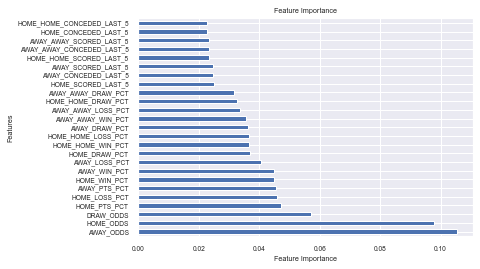

In [301]:
print('Executing the Random Forest model...')
Pkl_Filename = "{}/RandomForest.pkl".format(directory)
try:
    with open(Pkl_Filename, 'rb') as file:  
        rf = pickle.load(file)
except:
    rf = random_forest(dataset_train)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(rf, file)
results.append(dict(model='Random Forest',cm=rf[0], acc=rf[1], classifier=rf[2]))

In [302]:
print('Executing the Voting Classifier model...')
Pkl_Filename = "{}/VotingClassifier.pkl".format(directory)

estimators = [('lr', logisticRegression[2]), ('svm', svm[2]), ('nb', nb[2]), ('sgd', sgd[2])]
weights = [1,1,1,1]

try:
    with open(Pkl_Filename, 'rb') as file:  
        vc = pickle.load(file)
except:
    vc = voting_classifier(dataset, estimators, weights)
    with open(Pkl_Filename, 'wb') as file:  
        pickle.dump(vc, file)
results.append(dict(model='Voting Classifier',cm=vc[0], acc=vc[1], classifier=vc[2]))

Executing the Voting Classifier model...



Getting the feature correlation matrix...


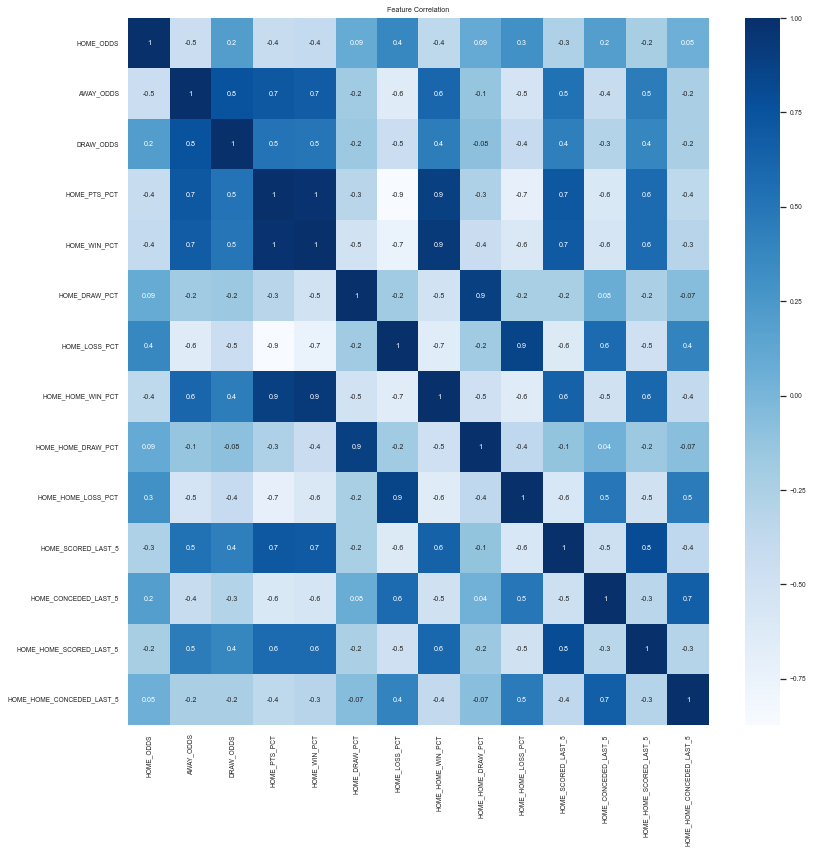

In [303]:
print('\nGetting the feature correlation matrix...')

import seaborn as sns

try:
    dependent_variables = dataset.iloc[:,5:20]
    corrmat = dependent_variables.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(13,13))
    title = 'Feature Correlation'
    plt.title(title)
    #plot heat map
    sns.set(font_scale=0.6)
    g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
    plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
    plt.show()
except:
    print('No correlation matrix for the selected model.')

In [304]:
directory = f'leagues/{league_id}/scalers'
if not os.path.exists(directory):
    os.makedirs(directory)

from sklearn.preprocessing import StandardScaler
sc_train = StandardScaler()
sc_train.fit(X_train)

Pkl_ScalerName = "{}/{}.pkl".format(directory, season)
with open(Pkl_ScalerName, 'wb') as file:  
    pickle.dump(sc_train, file)

X_transformed = sc_train.transform(X)

In [305]:
print('\nGetting classification model with the best predictions...')

modelCont = 0
highestAcc = 0
probs = dict()
total_invested = dict()
while True:
    try:
        total_invested[results[modelCont]['model']] = 0
        results[modelCont]['pred'] = results[modelCont]['classifier'].predict(X_transformed)
        probs[results[modelCont]['model']] = results[modelCont]['classifier'].predict_proba(X_transformed)
        results[modelCont]['acc_test'] = accuracy_score(y, results[modelCont]['pred'])
        if results[modelCont]['acc_test'] > highestAcc:
            y_pred = results[modelCont]['pred']
            highestAcc = results[modelCont]['acc_test']
            print('Using predictions from {} model: {}'.format(results[modelCont]['model'], results[modelCont]['acc_test']))
        modelCont += 1
    except IndexError:
        break

results.sort(key=lambda x: x['acc_test'], reverse=True)


Getting classification model with the best predictions...
Using predictions from Logistic Regression model: 0.5949820788530465
Using predictions from Kernel SVM model: 0.6057347670250897
Using predictions from Random Forest model: 0.8745519713261649


In [306]:
odds_baseline = dataset[((dataset['HOME_ODDS'] <= dataset['AWAY_ODDS']) & (dataset['HOME_ODDS'] <= dataset['DRAW_ODDS']) & (dataset['OUTCOME'] == 'H')) | 
                   ((dataset['AWAY_ODDS'] <= dataset['HOME_ODDS']) & (dataset['AWAY_ODDS'] <= dataset['DRAW_ODDS']) & (dataset['OUTCOME'] == 'A')) |
                       ((dataset['DRAW_ODDS'] <= dataset['HOME_ODDS']) & (dataset['DRAW_ODDS'] <= dataset['AWAY_ODDS']) & (dataset['OUTCOME'] == 'D'))]

print('\nResults Classification:')
results.sort(key=lambda x: x['acc_test'], reverse=True)
[print('{}:\t{:.4f}'.format(x['model'], x['acc_test'])) for x in results]
print('Baseline Odds:\t{:.4f}'.format(100*len(odds_baseline.index)/len(dataset.index)))


Results Classification:
Random Forest:	0.8746
Voting Classifier:	0.6272
Kernel SVM:	0.6057
Logistic Regression:	0.5950
Stochastic Gradient Descent:	0.5806
KNN:	0.5663
Naive Bayes:	0.5090
Baseline Odds:	59.4982


In [307]:
print('\nGetting the probabilities of the best model possible...')

for res in results:
    try:
        y_prob = res['classifier'].predict_proba(X_transformed)
        print('Using the {} model for probability tracking!'.format(res['model']))
        break
    except AttributeError:
        continue


Getting the probabilities of the best model possible...
Using the Random Forest model for probability tracking!


In [308]:
print('\nDisplaying data for the {} model...'.format(results[0]['model']))
cm = confusion_matrix(y.ravel(), y_pred.ravel())
acc_score = accuracy_score(y, y_pred)
print(cm)
print(acc_score)


Displaying data for the Random Forest model...
[[ 80   0  11]
 [  3  39  19]
 [  2   0 125]]
0.8745519713261649


In [309]:
for i in range(10):
    print(y_prob[i,:], y_pred[i])

[0.1631447  0.18217706 0.65467824] H
[0.64418058 0.17343644 0.18238298] A
[0.47270722 0.13243255 0.39486023] A
[0.07814814 0.4773819  0.44446996] D
[0.20041524 0.21373718 0.58584758] H
[0.24198113 0.42477603 0.33324284] D
[0.12480085 0.13856541 0.73663374] H
[0.28835959 0.45683086 0.25480955] D
[0.30231976 0.34742216 0.35025808] H
[0.2760906 0.1728762 0.5510332] H


In [310]:
def get_pred_odds(probs):
    return 1/probs[0], 1/probs[1], 1/probs[2] # Away, Draw, Home

In [311]:
print("\nGetting data from the regular models for visualization...")
right = 0
total = 0
profit = 0
money_by_date = []
bets_tracking_odds = [0]
money_by_team = dict()
bets = []
money_by_date.append([dataset.iloc[0,2], dict(zip([x['model'] for x in results], [0 for x in results])),  dict(zip([x['model'] for x in results], [0 for x in results]))])

for index, game in dataset.iterrows():
    if game['GAME_DATE'] != money_by_date[-1][0]:    
        bets_tracking_odds.append(bets_tracking_odds[-1])
        money_by_date.append([game['GAME_DATE'],  dict(zip([x['model'] for x in results], [0 for x in results])), dict(money_by_date[-1][2])])

    game_money = 0
    bet_value = get_bet_value(y_prob[index,0])
    
    if game['HOME_TEAM'] not in money_by_team:
        money_by_team[game['HOME_TEAM']] = 0
    if game['AWAY_TEAM'] not in money_by_team:
        money_by_team[game['AWAY_TEAM']] = 0
    
    pred_odds_away, pred_odds_draw, pred_odds_home  = get_pred_odds(y_prob[index,:])

    game_money = check_model_performance_on_game(game, y_pred[index], bet_value, pred_odds_home, pred_odds_away, pred_odds_draw)
    if game_money != 0:
        if game['OUTCOME'] == y_pred[index] and game['OUTCOME'] == 'H':
            bets.append(['HOME', game['HOME_ODDS'], pred_odds_home, 1])
            money_by_team[game['HOME_TEAM']] += game_money
        elif game['OUTCOME'] == y_pred[index] and game['OUTCOME'] == 'A':
            bets.append(['AWAY', game['AWAY_ODDS'], pred_odds_away, 1])
            money_by_team[game['AWAY_TEAM']] += game_money
        elif game['OUTCOME'] == y_pred[index] and game['OUTCOME'] == 'D':
            bets.append(['DRAW', game['DRAW_ODDS'], pred_odds_draw, 1])
        else:
            if y_pred[index] == 'H':
                bets.append(['HOME', game['HOME_ODDS'], pred_odds_home, 0])
                money_by_team[game['HOME_TEAM']] += game_money
            elif y_pred[index] == 'A':
                bets.append(['AWAY', game['AWAY_ODDS'], pred_odds_away, 0])
                money_by_team[game['AWAY_TEAM']] += game_money
            else:
                bets.append(['DRAW', game['DRAW_ODDS'], pred_odds_draw, 0])

        if game_money > 0:
            right += 1
        total += 1
        
    profit += game_money
    bets_tracking_odds[-1] += check_game_with_odds(game, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw)

    for model in money_by_date[-1][1]:
        game_money_model = 0
        if probs[model][index,0] != 1 and probs[model][index,0] != 0:
            bet_value = get_bet_value(probs[model][index,1])
            prediction = next(x['pred'][index] for x in results if x['model'] == model)
            pred_odds_away, pred_odds_draw, pred_odds_home = get_pred_odds(probs[model][index, :])
            game_money_model = check_model_performance_on_game(game, prediction, bet_value, pred_odds_home, pred_odds_away, pred_odds_draw)
        if game_money_model != 0:
            total_invested[model] += bet_value
        money_by_date[-1][1][model] += game_money_model
        money_by_date[-1][2][model] += game_money_model




Getting data from the regular models for visualization...


C:\Users\caiog\AppData\Local\Temp\ipykernel_16248\1250689490.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/probs[0], 1/probs[1], 1/probs[2] # Away, Draw, Home


In [312]:
print("Bets Result: {}/{} => {:.2f}%".format(right, total, right*100/total))

Bets Result: 149/149 => 100.00%


In [313]:
print('\nProfit and margin by model...')
for model in money_by_date[-1][1]:
    if total_invested[model] > 0:
        print('Model: {} \t// Invested: {} \t// Won: {:.2f} \t// Margin: {:.2f}%'.format(model, total_invested[model], money_by_date[-1][2][model], 100*money_by_date[-1][2][model]/total_invested[model]))


Profit and margin by model...
Model: Random Forest 	// Invested: 1490 	// Won: 3102.30 	// Margin: 208.21%
Model: Voting Classifier 	// Invested: 1300 	// Won: 571.70 	// Margin: 43.98%
Model: Kernel SVM 	// Invested: 1120 	// Won: 339.00 	// Margin: 30.27%
Model: Logistic Regression 	// Invested: 710 	// Won: 172.10 	// Margin: 24.24%
Model: Stochastic Gradient Descent 	// Invested: 1240 	// Won: 79.50 	// Margin: 6.41%
Model: KNN 	// Invested: 1300 	// Won: 408.60 	// Margin: 31.43%
Model: Naive Bayes 	// Invested: 1530 	// Won: -69.40 	// Margin: -4.54%


In [314]:
print('\nPlotting charts...')

models_tracking =  [np.array([x[2][model] for x in money_by_date], dtype=np.float32) for model in money_by_date[-1][1]]

money_by_date = np.array(money_by_date, dtype=str)
correct_bets = list(filter(lambda x: x[3] == 1, bets))
missed_bets = list(filter(lambda x: x[3] == 0, bets))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(money_by_team.items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


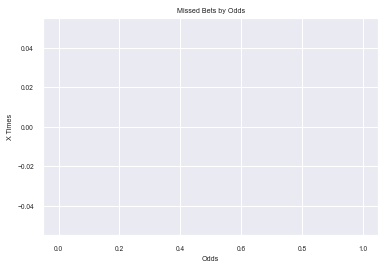

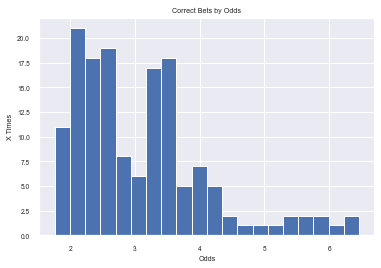

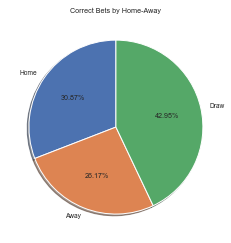

ValueError: 'label' must be of length 'x'

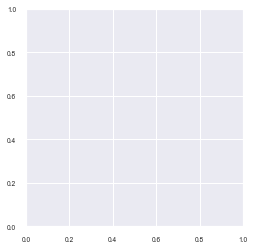

In [315]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away', 'Draw'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away', 'Draw'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

In [ ]:
xpoints = money_by_date[:,0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)
plt.plot(xpoints, bets_tracking_odds)

title = "Profit by Date"
plt.legend([x['model'] for x in results] + ['Odds Baseline'], loc=(1.04,0))
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()